# Implementando una red neuronal en PyTorch

Este notebook debes lanzarlo desde [Google Colab](https://colab.research.google.com/).

Antes de seguir trabajando, asegúrate de cambiar el entorno de ejecución (En el menú superior, "Entorno de ejecución"/"Cambiar el tipo de entorno de ejecución") a un "T4 GPU". Emplear un entorno con GPU hará que la práctica se ejecute considerablemente más rápido.

Para acceder al fichero de datos, una vez hayas abierto este notebook en Colab emplea el menú de la izquierda para acceder al gestor de archivos, que por defecto se abre en la carpeta Content. En esa misma carpeta sube el archivo
mnist.txt. Tendrás que repetir esta operación cada vez que lances este notebook, los datos se borran al cerrarlo.

**Atención:** Google Colab te permite acceder al fichero antes de que esté subido. Si la carga de datos falla, asegúrate de que la subida haya terminado y vuelve a intentarlo.

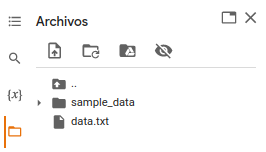

## Lectura de datos

La lectura de datos se realiza exactamente igual que en la práctica principal:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Lee los datos y guárdalos en data
# <RELLENAR>
Xraw = data[:, :-1]
yraw = data[:, -1]
print(Xraw.shape, yraw.shape)

Sin embargo, en PyTorch el tipo de datos por defecto no es el [np.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html#numpy.ndarray) de numpy. La magia de PyTorch es el trabajo en GPU, y aunque nosotros no tengamos que preocuparnos de los detalles, eso implica emplear una nueva clase base: el [torch.Tensor](https://pytorch.org/docs/stable/tensors.html).

Afortunadamente, la conversión es muy simple, solo debes usar la función [torch.tensor()](https://pytorch.org/docs/stable/generated/torch.tensor.html#torch.tensor) y pasarle el array de numpy que cargaste antes.

En el caso de la variable `X` pásala a formato [`float`](https://pytorch.org/docs/stable/generated/torch.Tensor.float.html) y en el caso de `y`, asegúrate de convertirla a formato [`long`](https://pytorch.org/docs/stable/generated/torch.Tensor.long.html).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# X = ...
# y = ...
# <RELLENAR>

# Pasamos los datos a la GPU. Estas líneas solo funcionan cuando estamos en un entorno
# de ejecución con tarjeta gráfica (T4 GPU en el caso de Colab)
X = X.to('cuda')
y = y.to('cuda')

Internamente, los Tensors de PyTorch gestionan el almacenamiento de los datos, facilitando el pasarlos entre GPU y CPU ([`Tensor.to`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html)).

## Definición de nuestra red

Definir una red neuronal básica en PyTorch es bastante simple: tan solo tenemos que extender la clase [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). En particular, necesitamos redefinir dos de sus métodos:

- `__init__`, donde se crean las capas y bloques necesarios para conformar nuetra red. En nuestro caso, vamos a recibir como parámetros el número de neuronas de la capa oculta y el número de etiquetas de salida.
- `forward`, donde se aplican esas capas para unos datos de entrada `x`.

Como ejemplo, aquí tienes una "red neuronal". Aunque el código es válido, si te fijas solamente hemos empleado una capa `nn.Linear`, por lo que realmente se comporta como 10 regresiones lógisticas independientes.

In [ ]:
 class SingleLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_labels):
        # Hay que llamar al constructor de la superclase
        super(SingleLayerNet, self).__init__()

        # Capa de neuronas de salida completamente conectada
        self.capa = nn.Linear(input_size, num_labels)

    def forward(self, x):
        # Aplicar la capa, seguida de la activación sigmoide
        z2 = self.capa(x)
        output = F.sigmoid(z2)

        return output

my_nn = SingleLayerNet(input_size=20*20, hidden_size=25, num_labels=10)
print(my_nn)

## Autograd

Como puedes observar, al definir esta red en ningún sitio hemos indicado las derivadas de las funciones para la retropropagación.

Al hacer uso de las funciones de PyTorch, el sistema de [autogradientes](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) que trae implementado nos ofrece las derivadas de cada paso de la red y de la función de loss automáticamente. Este sistema incluso hace el seguimiento de cómo se calculó cada Tensor, de manera que puede retropropagar él solo esos gradientes. Si además usamos un optimizador de los ya implementados en Pytorch, prácticamente no tenemos que preocuparnos de los gradientes.

📖 Revisa el tutorial oficial de [autogradientes](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) para entender mejor cómo funciona.

Para nuestras redes simples, solo tendremos que recordar:
- Reiniciar los gradientes del optimizador en cada minilote (`optimizer.zero_grad()`), ya que si no se acumularán.
- Realizar una llamada a [`backward`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) en el Tensor resultante sobre el que vayamos a retropropagar, en nuestro caso el loss final, `loss.backward()`. Al hacer la llamada, se calcularán los gradientes asociados a este loss y, siguiendo las derivadas, se retropropagarán a todas las variables que influyen en el loss. Los gradientes que se calculan estarán agregados para todos los ejemplos del minilote.
- Realizar un paso (`step`) del optimizador para aplicar los gradientes a los pesos de la red, actualizándolos.

Si en algún momento queremos usar la red sin retropropagar (para predecir en validación o test, por ejemplo), conviene usar `with torch.no_grad():` para evitar que ese segmento de código calcule los gradientes, que puede resultar un proceso costoso.

In [ ]:
def train_network(network, epochs, batch_size):
    # Creamos el optimizador y la función de loss
    optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.1)
    loss_func = nn.CrossEntropyLoss()

    # Para cada época y para cada minilote,
    for e in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            # Otenemos el minilote
            x_mini = X[i:i + batch_size]
            y_mini = y[i:i + batch_size]

            # Lo convertimos en variables de pytorch
            x_var = torch.autograd.Variable(x_mini)
            y_var = torch.autograd.Variable(y_mini)

            # Ponemos a cero los gradientes acumulados
            optimizer.zero_grad()
            # Aplicamos la red a la entrada
            net_out = network(x_var)

            # Obtenemos el loss entre la salida de la red y la salida real
            loss = loss_func(net_out, y_var)
            # Calculamos los gradientes a partir de ese loss
            loss.backward()
            # Y finalmente aplicamos los gradientes a los pesos
            optimizer.step()

        # Finalmente, tomamos métricas de la época (accuracy en train)
        with torch.no_grad():
            net_out = network(X)
            loss = loss_func(net_out, y)
            net_out = net_out.argmax(dim=1)
            acc = torch.sum(net_out == y) / y.shape[0]

        if e % 10 == 0:
            print('Epoch: {} - Loss: {:.6f}, Acc: {:.2f}'.format(e, loss.data, acc*100))

In [ ]:
# Creamos un objeto SingleLayerNet y lo pasamos a la GPU (donde ya están los datos)
my_nn = SingleLayerNet(input_size=20*20, hidden_size=25, num_labels=10).to('cuda')

# Configuración del entrenamiento
epochs = 250
batch_size = 5000

train_network(my_nn, epochs, batch_size)

## Red multicapa

Modifica el código de la red de una sola capa para crear una red con una capa oculta además de la capa de salida (ambas se pueden crear con [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)), y entrénala para ver su funcionamiento. A la hora de crear las capas, por defecto se crean con bias, así que no debes modificar nada al respecto (no hacen falta columnas de unos ni nada similar).

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_labels):
        # Hay que llamar al constructor de la superclase
        super(Net, self).__init__()

        # Capa oculta completamente conectada
        # self.capaoculta = ...
        # Capa de salida
        # self.capasalida = ...
        # <RELLENAR>

    def forward(self, x):

        # 1. Aplica la capa oculta a la entrada para obtener z2
        # 2. Aplica la sigmoide (F.sigmoid) a z2
        # 3. Aplica la capa de salida a la salida de 2 para obtener z3
        # 4. Finalmente, aplica la sigmoide otra vez y devuelve la salida (logits)
        # <RELLENAR>
        return output

In [ ]:
# Creamos un objeto Net y lo pasamos a la GPU (donde ya están los datos)
my_nn = Net(input_size=20*20, hidden_size=25, num_labels=10).to('cuda')
print(my_nn)

# Configuración del entrenamiento
epochs = 250
batch_size = 5000

train_network(my_nn, epochs, batch_size)



## Probando diferentes configuraciones

Como habrás observado, el entrenamiento acelerado por las GPUs en la nube de Google es extremadamente rápido. Por tanto, prueba a modificar las configuraciones (más o menos capas, tamaños de las capas, número de épocas y tamaño de lote) para ver como afecta al entrenamiento de la red, y qué configuraciones dan los mejores resultados.

In [ ]:
# <RELLENAR>